In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import json
import numpy 
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import pyarrow
import sys
import seaborn as sns

from datetime import date
from dotenv import load_dotenv
from sqlalchemy import create_engine
from os import path
from typing import List,Dict, Tuple
from collections import defaultdict
pd.set_option("display.max_columns", None)

load_dotenv(verbose=True)
BIGQUERY_CREDENTIALS_PATH = os.environ.get('BIGQUERY_CREDENTIALS_PATH')
engine = create_engine('bigquery://bespoke-financial/ProdMetrcData', credentials_path=os.path.expanduser(BIGQUERY_CREDENTIALS_PATH))

sys.path.append(path.realpath(path.join(os.getcwd(), "../core")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../src")))

import create_queries
import prepare_data

from bespoke.inventory.analysis.shared import download_util, inventory_types
from bespoke.inventory.analysis import active_inventory_util as util
from bespoke.inventory.analysis import inventory_valuations_util as valuations_util

%load_ext autoreload
%autoreload 2

# GM

In [3]:
#you can also query like this
blaze_gm_data = pd.read_sql_query("""
with base as 
(
   select
      *,
      last_day(week_start) year_month,
      retail_value / quantity_sold per_unit_price,
      cogs / quantity_sold per_unit_cost,
      sales.retail_value - sales.total_discount + sales.total_tax sales_post_tax_post_discount,
      sales.retail_value - sales.total_discount sales_pre_tax_post_discount,
      sales.retail_value sales_pre_tax_pre_discount,
   from
      blaze_data.sales sales
      -- EXCLUDE SAMPLES,DISPLAY,PROMO and test
   where
      lower(product_category) not like '%sample%' 
      and lower(product_category) not like '%display%' 
      and lower(product_category) not like '%promo%' 
      and lower(product_category) not like '%test%'
      and state = 'CA'
)
,
monthly_location_rev_and_cogs as 
(
   select
      year_month,
      shop_id shopid,
      company_id companyid,
      sum(sales_post_tax_post_discount) rev_post_tax_post_discount,
      sum(sales_pre_tax_post_discount) rev_pre_tax_post_discount,
      sum(sales_pre_tax_pre_discount) rev_pre_tax_pre_discount,
      sum(cogs) cogs 
   from
      base
      -- EXCLUDE low COGS items
   where
      cogs > 1 
      -- EXCLUDE high cost, high price items
      and per_unit_price <= 500 
      and per_unit_cost <= 500 
   group by
      2,
      3,
      1 
   order by
      2,
      3,
      1 
)
,
monthly_location_rev_and_cogs_and_profit as 
(
   select
      year_month,
      shopid,
      companyid,
      -- rev and cogs
      rev_post_tax_post_discount,
      rev_pre_tax_post_discount,
      rev_pre_tax_pre_discount,
      cogs,
      -- profit
      rev_post_tax_post_discount - cogs profit_post_tax_post_discount,
      rev_pre_tax_post_discount - cogs profit_pre_tax_post_discount,
      rev_pre_tax_pre_discount - cogs profit_pre_tax_pre_discount,
   from
      monthly_location_rev_and_cogs 
)
,
monthly_location_rev_and_cogs_and_profit_and_margin as 
(
   select
      year_month,
      shopid,
      companyid,
      -- rev and cogs
      rev_post_tax_post_discount,
      rev_pre_tax_post_discount,
      rev_pre_tax_pre_discount,
      cogs,
      -- profit
      profit_post_tax_post_discount,
      profit_pre_tax_post_discount,
      profit_pre_tax_pre_discount,
      -- margin
      profit_post_tax_post_discount / nullif(rev_post_tax_post_discount, 0) margin_post_tax_post_discount,
      profit_pre_tax_post_discount / nullif(rev_pre_tax_post_discount, 0) margin_pre_tax_post_discount,
      profit_pre_tax_pre_discount / nullif(rev_pre_tax_pre_discount, 0) margin_pre_tax_pre_discount 
   from
      monthly_location_rev_and_cogs_and_profit 
)
,
monthly_gm_analysis as 
(
   select
      year_month,
      shopid,
      companyid,
      -- CHOOSE TO USE PRE TAX POST DISCOUNT
      rev_pre_tax_post_discount,
      lag(rev_pre_tax_post_discount) over (partition by shopid order by year_month) lag_rev_pre_tax_post_discount,
      cogs,
      profit_pre_tax_post_discount,
      margin_pre_tax_post_discount,
      count(distinct year_month) over (partition by shopid ) month_available,
      sum(cogs) over (partition by shopid order by year_month rows between 2 preceding and current row ) sum_cogs_3m,
      avg(margin_pre_tax_post_discount) over (partition by shopid order by year_month rows between 2 preceding and current row ) avg_margin_3m,
      avg(margin_pre_tax_post_discount) over (partition by shopid order by year_month rows between 5 preceding and current row ) avg_margin_6m,
      avg(margin_pre_tax_post_discount) over (partition by shopid order by year_month ) avg_margin_all 
   from
      monthly_location_rev_and_cogs_and_profit_and_margin 
)
select
   *,
   (
      rev_pre_tax_post_discount - lag_rev_pre_tax_post_discount
   )
   / nullif(lag_rev_pre_tax_post_discount, 0) rev_change 
from
   monthly_gm_analysis
   where shopid not in ("5e50449d6c0a910843356fa3",
                        "5e666af1aa809b085a98a646",
                        "56cf846ee38179985229e59e",
                        "5e6d0948b987950831b5092c",
                        "5ab806d6c182bb072e0b0e01",
                        "617b7da0e5cb65322b32781a",
                        "56cf84e4e38179985229e59f",
                        "5ee7c6a938fa9a08c8b7939c",
                        "5eebecd661ea0b08cdbcc386",
                        "56cf855ce38179985229e5a0",
                        "5ef12ad7bb5e7a08c5b3f4f3",
                        "5f1108355ae12008f4fef76e",
                        "5f123a5d12497908d2888dde",
                        "5f2309d579373608c93e6742",
                        "5f341ed02fdd5608e0821b45",
                        "5f8870200260fe08fe708db5",
                        "5f8870200260fe08fe708db6",
                        "5fac6a0b0643cc08efd1d327",
                        "56cf855ce38179985229e5a1",
                        "5d238c1955be2e07f5ee66e5",
                        "57b35a5d920f401e40146301",
                        "603d1a9eb9d7dc08cca27203",
                        "603d1a9eb9d7dc08cca27204",
                        "6046544f61e17808cff96fdb",
                        "6046544f61e17808cff96fdc",
                        "57b35aa8920f401e40146334",
                        "57b6b145920f4045cbe5fe81",
                        "6059219abe32aa08fa3a11dc",
                        "57b6b36a920f4046337f2618",
                        "58a7433f819d9e6ebd427617",
                        "60c0ffd6331cab296f02f49a",
                        "610c0a0d381ba0747c981ce9",
                        "611c0c98127cdd740cff94db",
                        "5a43f72b819d9e3ef9373675",
                        "611c0cc403d2e97dc2c159b0",
                        "5e6d0ac5b987950831b513e3",
                        "5a4563f1819d9e4ae6207e06",
                        "611c0ce7649819050ed4906b",
                        "611c0d02f572ec7882d64eea",
                        "611c0d26d5f1e86542fe3b8b",
                        "61672305b5e382719c7e4c2a",
                        "616dee0e4497e822dae13b21",
                        "616e5b13dd10fe4d3f34fd05",
                        "616e5b13dd10fe4d3f34fd06",
                        "619834e921c8017e23135674",
                        "5ab2d1a5819d9e21137cec3c",
                        "61bb746b82fddc50e058d711",
                        "61c3be757511d81170a29d51",
                        "61d49080eec1b51a3e33dc39",
                        "61d8912bdd71d40c2b68c5b3",
                        "61ba4efb9536472be6a8baa9",
                        "61d895fb3efbfb6da5210ae3",
                        "61d8aaf527205210191d7a1e",
                        "61e72d51073c4a79cfeccb62",
                        "61fdab9eae59d05c49422c3a",
                        "6202bd1c15425361f688aabf",
                        "6202bd1c15425361f688aac0",
                        "5b9f8e1db93307080d35b85f",
                        "5c2c250eabe12808989ac2f7",
                        "58be5603c182bb1f9bcd2ad5",
                        "5c8be64665a6a40808118621",
                        "606761051436a608e166db19",
                        "5ce2eb562d4dcf07fb7d0c5f",
                        "6176fa9eda707b1faba5f717",
                        "5b517867485da70830fcc04e",
                        "5b9f841a17b6e00812fe71f3",
                        "5da023586d8ce1082b9c91bd",
                        "5bbce3db420c21083300e410",
                        "5d238c1955be2e07f5ee66e4",
                        "5b209459062bd807b142a1f6",
                        "5cb1a5839fbb5f0818f6de55",
                        "5cda1adb183d6a0801347027",
                        "5be3903b79015e083194aa70",
                        "5d1ba174cdbd6d0803c99cfd",
                        "5a8a6eb8819d9e78641ab6ec",
                        "5db863825a04a2083b464083",
                        "5d8a7fb3a3274308311743d5",
                        "5d8a7fb3a3274308311743d6",
                        "5d9e425d52d15b0824a8a5d5",
                        "5dd6da52ce4015084c72e8db",
                        "5e07f51837cdd7082662f3c6",
                        "5e4d849981e3cd08326b6c14",
                        "5dfd2308fa462a086a8bfab8",
                        "5e0ee2710a7b7008346b06b4",
                        "5e4d849981e3cd08326b6c15",
                        "5dfd2308fa462a086a8bfab9",
                        "5e6d0adc12f2e208728f9369",
                        "5e6d0948b987950831b5092b",
                        "5ed589d96c0bf408dcc92d97",
                        "5eebecd761ea0b08cdbcc387",
                        "5ef12ad7bb5e7a08c5b3f4f2",
                        "5f63afd430bd7208ce1ab304",
                        "5f63afd430bd7208ce1ab305",
                        "5bf5ce54062bd807e436b473",
                        "5fac691a715f3808cd0aa82d",
                        "5d9d7fc27e2e46081e7e69f3",
                        "6034287d52503608c0b3ca48",
                        "5dfd40ea521ea90860c91848",
                        "6034287d52503608c0b3ca49",
                        "60636227ec491108d1c970d5",
                        "5a9a2274c182bb4ec00a72ca",
                        "60aea3bb1940943cecec2dbf",
                        "60a2f1610f75543c8e7dde50",
                        "5eb98f2d649a6508f87a6436",
                        "5e62a68447d90a086b8231c0",
                        "5e62a68447d90a086b8231c1",
                        "615b634cac08aa0a794158c4",
                        "60a2db8d0f75543c8e7d513b",
                        "60a2db8d0f75543c8e7d513c",
                        "60a4051e67406e7edad8ab88",
                        "60c0ff66082dcc61e42ad4a6",
                        "60c0ff66082dcc61e42ad4a7",
                        "6046c57057abe808d1f260fd",
                        "60636227ec491108d1c970d4",
                        "610abcaec3d09859f9b630d1",
                        "606cfaadba253e08c4189a63",
                        "607a321441cfa308f6e65b58",
                        "6197e31b21c8017e2310c10e",
                        "611d457db7c6f80914292394",
                        "610c0a0d381ba0747c981cea",
                        "610abcaec3d09859f9b630d2",
                        "611c0cb3a29e0f598f108a60",
                        "5fff453a81a63608d3a1a5b7",
                        "615237cc0937e52684b6c134",
                        "620b59c97852ca7a7dcc6f05",
                        "6196aa4deb62c87eba4014ad",
                        "619816781f88a1280f8a0c28",
                        "61d7b217a42c2f124d9b76b1",
                        "61cf4b452bc6657512b92d2a",
                        "61ebb060b04dc7510465f774",
                        "61eedaa0b882812f2f46a23d",
                        "61eedade6716dd2a2e0cfce5",
                        "5e6d0ae6e4a25a0834047467",
                        "5dc3315fe0faca07c6dfe849",
                        "5f7e17594445b008d2f63ebd",
                        "5f7f63053dbcad08cc9edbfb",
                        "5fff453a81a63608d3a1a5b8",
                        "603d5425a9ca7208f886d156",
                        "60e48dbbd5596d7c8a1d24dc",
                        "611c0d335901162ff90ef4dd",
                        "613f771aa96c863c00c1517d",
                        "6153b70fd343dc6230c4b67d",
                        "61699cdf032e1c1f920ec70f",
                        "61699cdf032e1c1f920ec710",
                        "61a7b4c6c8c7d85ea1846f14",
                        "61c390cfb863cb3baddb70f4",
                        "61d7b252ae999342ac05499e",
                        "61e6f857c5da34762f1c1fb5",
                        "61ebb00a335a531542342a32",
                        "620b59c97852ca7a7dcc6f04",
                        "6226640755810d3311e8ecd0")
""",engine)

In [4]:
blaze_gm_data['year_month'] = pd.to_datetime(blaze_gm_data['year_month'])

In [5]:
blaze_gm_data['shopid'].nunique()

339

In [6]:
blaze_gm_data[['year_month','shopid']].groupby(['year_month']).nunique()

,shopid
year_month,
2021-08-31,234
2021-09-30,246
2021-10-31,258
2021-11-30,257
2021-12-31,267
2022-01-31,263
2022-02-28,264
2022-03-31,273
2022-04-30,268


In [7]:
blaze_gm_data_long = blaze_gm_data[blaze_gm_data['month_available'] >= 6]

In [8]:
blaze_gm_data_long[['year_month','shopid']].groupby(['year_month']).nunique()

,shopid
year_month,
2021-08-31,202
2021-09-30,212
2021-10-31,220
2021-11-30,236
2021-12-31,235
2022-01-31,234
2022-02-28,230
2022-03-31,228
2022-04-30,223


In [9]:
blaze_gm_data_long[blaze_gm_data_long['year_month'] == '2022-04-30'][['shopid','month_available']].groupby(['month_available']).nunique()



,shopid
month_available,
6,12
7,13
8,14
9,184


## MoM margin

In [10]:
# mom margin
gm_distr_mom = blaze_gm_data_long.groupby(['year_month'])['margin_pre_tax_post_discount'].describe().reset_index()
gm_distr_mom.index = pd.to_datetime(gm_distr_mom['year_month'])
gm_distr_mom

,year_month,count,mean,std,min,25%,50%,75%,max
year_month,,,,,,,,,
2021-08-31,2021-08-31,202.0,0.511990,0.219890,-1.844289,0.466109,0.525062,0.589130,0.985539
2021-09-30,2021-09-30,212.0,0.504888,0.338576,-3.842419,0.475849,0.533441,0.592142,0.985197
2021-10-31,2021-10-31,220.0,0.515552,0.211112,-1.859963,0.470740,0.528930,0.593019,0.989650
2021-11-30,2021-11-30,236.0,0.523112,0.158122,-0.957678,0.464574,0.525527,0.590263,0.991827
2021-12-31,2021-12-31,235.0,0.531677,0.126757,-0.177532,0.469801,0.528850,0.598872,0.989949
2022-01-31,2022-01-31,234.0,0.535319,0.125557,-0.206337,0.480965,0.533870,0.600365,0.993993
2022-02-28,2022-02-28,230.0,0.508564,0.313885,-3.669029,0.466503,0.538781,0.593509,0.990898
2022-03-31,2022-03-31,228.0,0.528795,0.164007,-1.143141,0.467297,0.546403,0.597487,0.980181
2022-04-30,2022-04-30,223.0,0.519805,0.163518,-0.726965,0.466552,0.538454,0.596027,0.921176


In [11]:
round(gm_distr_mom[['25%','50%','75%']].mean(),2)

25%    0.47
50%    0.53
75%    0.59
dtype: float64

In [12]:
round(blaze_gm_data_long['margin_pre_tax_post_discount'].quantile(0.95),2)

0.7

## 3m

In [13]:
gm_distr_3m = blaze_gm_data_long.groupby(['year_month'])['avg_margin_3m'].describe().reset_index()
gm_distr_3m.index = pd.to_datetime(gm_distr_3m['year_month'])
gm_distr_3m

,year_month,count,mean,std,min,25%,50%,75%,max
year_month,,,,,,,,,
2021-08-31,2021-08-31,202.0,0.511990,0.219890,-1.844289,0.466109,0.525062,0.589130,0.985539
2021-09-30,2021-09-30,212.0,0.510393,0.256807,-2.181210,0.473240,0.526310,0.590152,0.985368
2021-10-31,2021-10-31,220.0,0.519119,0.184944,-1.533472,0.472501,0.527900,0.589138,0.986795
2021-11-30,2021-11-30,236.0,0.512137,0.208629,-1.422507,0.471437,0.525204,0.589960,0.988891
2021-12-31,2021-12-31,235.0,0.517696,0.192209,-1.266981,0.469074,0.528473,0.586283,0.990475
2022-01-31,2022-01-31,234.0,0.530423,0.131696,-0.397322,0.467713,0.529183,0.594188,0.991923
2022-02-28,2022-02-28,230.0,0.524158,0.159655,-0.947387,0.466433,0.533263,0.595782,0.991613
2022-03-31,2022-03-31,228.0,0.523370,0.168602,-0.929169,0.462865,0.537340,0.591503,0.988357
2022-04-30,2022-04-30,223.0,0.519086,0.174070,-0.817287,0.467302,0.536274,0.594228,0.934692


In [14]:
round(gm_distr_3m[['25%','50%','75%']].mean(),2)

25%    0.47
50%    0.53
75%    0.59
dtype: float64

In [15]:
round(blaze_gm_data_long['avg_margin_3m'].quantile(0.95),2)

0.69

## 6m

In [16]:
gm_distr_6m = blaze_gm_data_long.groupby(['year_month'])['avg_margin_6m'].describe().reset_index()
gm_distr_6m.index = pd.to_datetime(gm_distr_6m['year_month'])
gm_distr_6m

,year_month,count,mean,std,min,25%,50%,75%,max
year_month,,,,,,,,,
2021-08-31,2021-08-31,202.0,0.511990,0.219890,-1.844289,0.466109,0.525062,0.589130,0.985539
2021-09-30,2021-09-30,212.0,0.510393,0.256807,-2.181210,0.473240,0.526310,0.590152,0.985368
2021-10-31,2021-10-31,220.0,0.519119,0.184944,-1.533472,0.472501,0.527900,0.589138,0.986795
2021-11-30,2021-11-30,236.0,0.511451,0.212712,-1.422507,0.471141,0.523453,0.586350,0.988053
2021-12-31,2021-12-31,235.0,0.516037,0.188892,-1.118417,0.473405,0.523640,0.585804,0.988432
2022-01-31,2022-01-31,234.0,0.519653,0.173714,-0.965397,0.471088,0.527691,0.588982,0.989359
2022-02-28,2022-02-28,230.0,0.516895,0.167944,-0.740334,0.466549,0.527416,0.589547,0.990252
2022-03-31,2022-03-31,228.0,0.520191,0.161995,-0.781497,0.463783,0.530899,0.590611,0.989416
2022-04-30,2022-04-30,223.0,0.523895,0.144150,-0.550597,0.467544,0.533235,0.592722,0.958570


In [17]:
round(gm_distr_6m[['25%','50%','75%']].mean(),2)

25%    0.47
50%    0.53
75%    0.59
dtype: float64

In [18]:
round(blaze_gm_data_long['avg_margin_6m'].quantile(0.95),2)

0.69

## all time

In [19]:
gm_distr_all = blaze_gm_data_long.groupby(['year_month'])['avg_margin_all'].describe().reset_index()
gm_distr_all.index = pd.to_datetime(gm_distr_all['year_month'])
round(gm_distr_all,3)

,year_month,count,mean,std,min,25%,50%,75%,max
year_month,,,,,,,,,
2021-08-31,2021-08-31,202.0,0.512,0.220,-1.844,0.466,0.525,0.589,0.986
2021-09-30,2021-09-30,212.0,0.510,0.257,-2.181,0.473,0.526,0.590,0.985
2021-10-31,2021-10-31,220.0,0.519,0.185,-1.533,0.473,0.528,0.589,0.987
2021-11-30,2021-11-30,236.0,0.511,0.213,-1.423,0.471,0.523,0.586,0.988
2021-12-31,2021-12-31,235.0,0.516,0.189,-1.118,0.473,0.524,0.586,0.988
2022-01-31,2022-01-31,234.0,0.520,0.174,-0.965,0.471,0.528,0.589,0.989
2022-02-28,2022-02-28,230.0,0.515,0.172,-0.898,0.469,0.526,0.591,0.990
2022-03-31,2022-03-31,228.0,0.518,0.166,-0.929,0.466,0.527,0.590,0.988
2022-04-30,2022-04-30,223.0,0.518,0.162,-0.878,0.467,0.530,0.590,0.968


In [20]:
round(gm_distr_all[['25%','50%','75%']].mean(),2)

25%    0.47
50%    0.53
75%    0.59
dtype: float64

In [21]:
round(blaze_gm_data_long['avg_margin_all'].quantile(0.95),2)

0.69

# Rev change

In [22]:
def gmv_change_variance_point_mapping(x):
    if x < -0.1:
        return -5
    elif x >= -0.1 and x <-0.05:
        return -2.5
    elif x >= -0.05 and x < 0:
        return 0
    elif x >= 0 and x < 0.05:
        return 5
    elif x >= 0.05 and x <= 0.5:
        return 10
    else:
        return numpy.nan
    

In [23]:
rev_change_bm = blaze_gm_data_long.groupby(['year_month'])['rev_change'].describe().reset_index()
rev_change_bm.index = pd.to_datetime(rev_change_bm['year_month'])
rev_change_bm

,year_month,count,mean,std,min,25%,50%,75%,max
year_month,,,,,,,,,
2021-08-31,2021-08-31,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-30,2021-09-30,200.0,3.910086,47.235276,-0.583663,0.136835,0.203317,0.278959,667.214941
2021-10-31,2021-10-31,210.0,2.666193,27.517339,-0.865051,-0.021650,0.028046,0.090474,394.366300
2021-11-30,2021-11-30,224.0,6.923945,83.696664,-0.879068,-0.121066,-0.054976,0.006789,1221.495722
2021-12-31,2021-12-31,235.0,0.462674,2.899744,-0.825981,-0.009764,0.055012,0.134821,34.464060
2022-01-31,2022-01-31,234.0,-0.015628,0.412656,-0.942798,-0.114923,-0.060473,-0.016425,2.615850
2022-02-28,2022-02-28,230.0,-0.048553,0.397180,-0.904537,-0.120819,-0.062732,-0.009129,5.115462
2022-03-31,2022-03-31,228.0,0.131297,0.783398,-0.999341,0.024174,0.094947,0.156497,10.978361
2022-04-30,2022-04-30,223.0,7.386797,109.051180,-0.950140,-0.054423,-0.000284,0.074736,1628.531706


In [24]:
#you can also query like this
blaze_ca_gmv_change_data = pd.read_sql_query("""
---------------------------------------------------------------------------------------------------------------------
with base as
(
   select
      shop_id,
      company_id,
      last_day(week_start) year_month,
      sales.retail_value - sales.total_discount sales_pre_tax_post_discount
   from
      blaze_data.sales sales

   where
      lower(product_category) not like '%sample%'
      and lower(product_category) not like '%display%'
      and lower(product_category) not like '%promo%'
      and lower(product_category) not like '%test%'
      and state = 'CA'
      and shop_id not in ("5e50449d6c0a910843356fa3",
                        "5e666af1aa809b085a98a646",
                        "56cf846ee38179985229e59e",
                        "5e6d0948b987950831b5092c",
                        "5ab806d6c182bb072e0b0e01",
                        "617b7da0e5cb65322b32781a",
                        "56cf84e4e38179985229e59f",
                        "5ee7c6a938fa9a08c8b7939c",
                        "5eebecd661ea0b08cdbcc386",
                        "56cf855ce38179985229e5a0",
                        "5ef12ad7bb5e7a08c5b3f4f3",
                        "5f1108355ae12008f4fef76e",
                        "5f123a5d12497908d2888dde",
                        "5f2309d579373608c93e6742",
                        "5f341ed02fdd5608e0821b45",
                        "5f8870200260fe08fe708db5",
                        "5f8870200260fe08fe708db6",
                        "5fac6a0b0643cc08efd1d327",
                        "56cf855ce38179985229e5a1",
                        "5d238c1955be2e07f5ee66e5",
                        "57b35a5d920f401e40146301",
                        "603d1a9eb9d7dc08cca27203",
                        "603d1a9eb9d7dc08cca27204",
                        "6046544f61e17808cff96fdb",
                        "6046544f61e17808cff96fdc",
                        "57b35aa8920f401e40146334",
                        "57b6b145920f4045cbe5fe81",
                        "6059219abe32aa08fa3a11dc",
                        "57b6b36a920f4046337f2618",
                        "58a7433f819d9e6ebd427617",
                        "60c0ffd6331cab296f02f49a",
                        "610c0a0d381ba0747c981ce9",
                        "611c0c98127cdd740cff94db",
                        "5a43f72b819d9e3ef9373675",
                        "611c0cc403d2e97dc2c159b0",
                        "5e6d0ac5b987950831b513e3",
                        "5a4563f1819d9e4ae6207e06",
                        "611c0ce7649819050ed4906b",
                        "611c0d02f572ec7882d64eea",
                        "611c0d26d5f1e86542fe3b8b",
                        "61672305b5e382719c7e4c2a",
                        "616dee0e4497e822dae13b21",
                        "616e5b13dd10fe4d3f34fd05",
                        "616e5b13dd10fe4d3f34fd06",
                        "619834e921c8017e23135674",
                        "5ab2d1a5819d9e21137cec3c",
                        "61bb746b82fddc50e058d711",
                        "61c3be757511d81170a29d51",
                        "61d49080eec1b51a3e33dc39",
                        "61d8912bdd71d40c2b68c5b3",
                        "61ba4efb9536472be6a8baa9",
                        "61d895fb3efbfb6da5210ae3",
                        "61d8aaf527205210191d7a1e",
                        "61e72d51073c4a79cfeccb62",
                        "61fdab9eae59d05c49422c3a",
                        "6202bd1c15425361f688aabf",
                        "6202bd1c15425361f688aac0",
                        "5b9f8e1db93307080d35b85f",
                        "5c2c250eabe12808989ac2f7",
                        "58be5603c182bb1f9bcd2ad5",
                        "5c8be64665a6a40808118621",
                        "606761051436a608e166db19",
                        "5ce2eb562d4dcf07fb7d0c5f",
                        "6176fa9eda707b1faba5f717",
                        "5b517867485da70830fcc04e",
                        "5b9f841a17b6e00812fe71f3",
                        "5da023586d8ce1082b9c91bd",
                        "5bbce3db420c21083300e410",
                        "5d238c1955be2e07f5ee66e4",
                        "5b209459062bd807b142a1f6",
                        "5cb1a5839fbb5f0818f6de55",
                        "5cda1adb183d6a0801347027",
                        "5be3903b79015e083194aa70",
                        "5d1ba174cdbd6d0803c99cfd",
                        "5a8a6eb8819d9e78641ab6ec",
                        "5db863825a04a2083b464083",
                        "5d8a7fb3a3274308311743d5",
                        "5d8a7fb3a3274308311743d6",
                        "5d9e425d52d15b0824a8a5d5",
                        "5dd6da52ce4015084c72e8db",
                        "5e07f51837cdd7082662f3c6",
                        "5e4d849981e3cd08326b6c14",
                        "5dfd2308fa462a086a8bfab8",
                        "5e0ee2710a7b7008346b06b4",
                        "5e4d849981e3cd08326b6c15",
                        "5dfd2308fa462a086a8bfab9",
                        "5e6d0adc12f2e208728f9369",
                        "5e6d0948b987950831b5092b",
                        "5ed589d96c0bf408dcc92d97",
                        "5eebecd761ea0b08cdbcc387",
                        "5ef12ad7bb5e7a08c5b3f4f2",
                        "5f63afd430bd7208ce1ab304",
                        "5f63afd430bd7208ce1ab305",
                        "5bf5ce54062bd807e436b473",
                        "5fac691a715f3808cd0aa82d",
                        "5d9d7fc27e2e46081e7e69f3",
                        "6034287d52503608c0b3ca48",
                        "5dfd40ea521ea90860c91848",
                        "6034287d52503608c0b3ca49",
                        "60636227ec491108d1c970d5",
                        "5a9a2274c182bb4ec00a72ca",
                        "60aea3bb1940943cecec2dbf",
                        "60a2f1610f75543c8e7dde50",
                        "5eb98f2d649a6508f87a6436",
                        "5e62a68447d90a086b8231c0",
                        "5e62a68447d90a086b8231c1",
                        "615b634cac08aa0a794158c4",
                        "60a2db8d0f75543c8e7d513b",
                        "60a2db8d0f75543c8e7d513c",
                        "60a4051e67406e7edad8ab88",
                        "60c0ff66082dcc61e42ad4a6",
                        "60c0ff66082dcc61e42ad4a7",
                        "6046c57057abe808d1f260fd",
                        "60636227ec491108d1c970d4",
                        "610abcaec3d09859f9b630d1",
                        "606cfaadba253e08c4189a63",
                        "607a321441cfa308f6e65b58",
                        "6197e31b21c8017e2310c10e",
                        "611d457db7c6f80914292394",
                        "610c0a0d381ba0747c981cea",
                        "610abcaec3d09859f9b630d2",
                        "611c0cb3a29e0f598f108a60",
                        "5fff453a81a63608d3a1a5b7",
                        "615237cc0937e52684b6c134",
                        "620b59c97852ca7a7dcc6f05",
                        "6196aa4deb62c87eba4014ad",
                        "619816781f88a1280f8a0c28",
                        "61d7b217a42c2f124d9b76b1",
                        "61cf4b452bc6657512b92d2a",
                        "61ebb060b04dc7510465f774",
                        "61eedaa0b882812f2f46a23d",
                        "61eedade6716dd2a2e0cfce5",
                        "5e6d0ae6e4a25a0834047467",
                        "5dc3315fe0faca07c6dfe849",
                        "5f7e17594445b008d2f63ebd",
                        "5f7f63053dbcad08cc9edbfb",
                        "5fff453a81a63608d3a1a5b8",
                        "603d5425a9ca7208f886d156",
                        "60e48dbbd5596d7c8a1d24dc",
                        "611c0d335901162ff90ef4dd",
                        "613f771aa96c863c00c1517d",
                        "6153b70fd343dc6230c4b67d",
                        "61699cdf032e1c1f920ec70f",
                        "61699cdf032e1c1f920ec710",
                        "61a7b4c6c8c7d85ea1846f14",
                        "61c390cfb863cb3baddb70f4",
                        "61d7b252ae999342ac05499e",
                        "61e6f857c5da34762f1c1fb5",
                        "61ebb00a335a531542342a32",
                        "620b59c97852ca7a7dcc6f04",
                         "6226640755810d3311e8ecd0")
)
,
monthly_rev as
(
   select
      year_month,
      sum(sales_pre_tax_post_discount) rev_pre_tax_post_discount,
      count(distinct shop_id) count_shop
   from
      base
   group by
1
),

monthly_rev_with_lag as
(
   select
      year_month,
      rev_pre_tax_post_discount,
      count_shop,
      lag(rev_pre_tax_post_discount) over (order by year_month) lag_rev_pre_tax_post_discount,
      lag(count_shop) over (order by year_month) lag_count_shop
   from
      monthly_rev
)
select
   *,
    rev_pre_tax_post_discount / count_shop rev_per_shop,
       lag_rev_pre_tax_post_discount / lag_count_shop lag_rev_per_shop,
   (
      rev_pre_tax_post_discount / count_shop - lag_rev_pre_tax_post_discount / lag_count_shop
   )
   / nullif(lag_rev_pre_tax_post_discount / lag_count_shop, 0) rev_change
from
   monthly_rev_with_lag
order by year_month
""",engine)

In [25]:
blaze_ca_gmv_change_data['year_month'] = pd.to_datetime(blaze_ca_gmv_change_data['year_month'])

<AxesSubplot:>

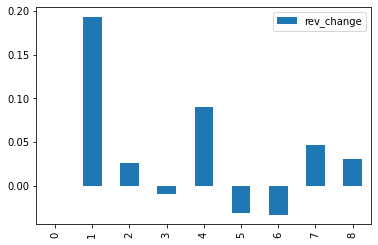

In [26]:
blaze_ca_gmv_change_data[['rev_change']].plot(kind = 'bar')

In [27]:
rev_change_bm_with_weight = blaze_ca_gmv_change_data[['year_month','rev_change']]
rev_change_bm_with_weight['weight'] = [numpy.nan,0.44,0.52,0.6,0.68,0.76,0.84,0.92,1]
rev_change_bm_with_weight.columns = ['year_month','rev_change_bm','rev_change_weight']
rev_change_bm_with_weight = rev_change_bm_with_weight.reset_index(drop = True)
rev_change_bm_with_weight

,year_month,rev_change_bm,rev_change_weight
0,2021-08-31,NaN,NaN
1,2021-09-30,0.193337,0.44
2,2021-10-31,0.025708,0.52
3,2021-11-30,-0.009270,0.60
4,2021-12-31,0.090346,0.68
5,2022-01-31,-0.030930,0.76
6,2022-02-28,-0.033000,0.84
7,2022-03-31,0.046490,0.92
8,2022-04-30,0.030995,1.00


In [28]:

blaze_gm_data_long_with_rev  = pd.merge(blaze_gm_data_long,rev_change_bm_with_weight,on=['year_month'], how='inner')
blaze_gm_data_long_with_rev['rev_change_var'] = blaze_gm_data_long_with_rev['rev_change'] - blaze_gm_data_long_with_rev['rev_change_bm']
blaze_gm_data_long_with_rev['rev_change_points'] = [gmv_change_variance_point_mapping(n) for n in blaze_gm_data_long_with_rev['rev_change_var']]
blaze_gm_data_long_with_rev['rev_change_total'] = blaze_gm_data_long_with_rev['rev_change_points'] * blaze_gm_data_long_with_rev['rev_change_weight']



In [29]:
blaze_gm_data_long_with_rev.tail()

,year_month,shopid,companyid,rev_pre_tax_post_discount,lag_rev_pre_tax_post_discount,cogs,profit_pre_tax_post_discount,margin_pre_tax_post_discount,month_available,sum_cogs_3m,avg_margin_3m,avg_margin_6m,avg_margin_all,rev_change,rev_change_bm,rev_change_weight,rev_change_var,rev_change_points,rev_change_total
2015,2022-04-30,5d8b22b15213710855c34190,5d8b22b15213710855c34170,19821.98,17846.57,8483.53,11338.45,0.572014,9,21993.53,0.591757,0.590118,0.562882,0.110688,0.030995,1.0,0.079693,10.0,10.0
2016,2022-04-30,611a90e4a5c5393655da2294,611a90e4a5c5393655da227b,64956.56,63151.99,13843.17,51113.39,0.786886,7,52760.26,0.716164,0.696037,0.704727,0.028575,0.030995,1.0,-0.002420,0.0,0.0
2017,2022-04-30,6195ba5eeb17b71a008e3c77,5e8b520200aa8008dee7e479,256525.99,253187.86,106847.92,149678.07,0.583481,6,319418.67,0.567306,0.529734,0.529734,0.013184,0.030995,1.0,-0.017811,0.0,0.0
2018,2022-04-30,5d65d142725a93082f22de8c,5d65d142725a93082f22de75,441974.28,457228.70,269533.06,172441.22,0.390161,9,799219.23,0.381540,0.381546,0.384096,-0.033363,0.030995,1.0,-0.064358,-2.5,-2.5
2019,2022-04-30,5e501db75dc1390833d258e4,5dc9d1b480636c0823c20399,344698.65,371828.22,150959.07,193739.58,0.562055,9,451228.04,0.571586,0.568600,0.564111,-0.072963,0.030995,1.0,-0.103958,-5.0,-5.0


# inventory

In [30]:
blaze_inv_data_snap = pd.read_sql_query("""
with base as (
    select *,
    last_day(date) year_month,
    current_quantity * unit_cost total_value
    from blaze_data.inventory
    where  lower(product_category) not like '%sample%'
    and lower(product_category) not like '%display%'
    and lower(product_category) not like '%promo%'
    and lower(product_category) not like '%test%'
    -- EXCLUDE SMALL COGS
    and unit_cost > 0.01
    and current_quantity > 0
    and current_quantity < 1000
    and date in ('2022-04-24')
    and state = 'CA'
    and shop_id not in ("5e50449d6c0a910843356fa3",
                        "5e666af1aa809b085a98a646",
                        "56cf846ee38179985229e59e",
                        "5e6d0948b987950831b5092c",
                        "5ab806d6c182bb072e0b0e01",
                        "617b7da0e5cb65322b32781a",
                        "56cf84e4e38179985229e59f",
                        "5ee7c6a938fa9a08c8b7939c",
                        "5eebecd661ea0b08cdbcc386",
                        "56cf855ce38179985229e5a0",
                        "5ef12ad7bb5e7a08c5b3f4f3",
                        "5f1108355ae12008f4fef76e",
                        "5f123a5d12497908d2888dde",
                        "5f2309d579373608c93e6742",
                        "5f341ed02fdd5608e0821b45",
                        "5f8870200260fe08fe708db5",
                        "5f8870200260fe08fe708db6",
                        "5fac6a0b0643cc08efd1d327",
                        "56cf855ce38179985229e5a1",
                        "5d238c1955be2e07f5ee66e5",
                        "57b35a5d920f401e40146301",
                        "603d1a9eb9d7dc08cca27203",
                        "603d1a9eb9d7dc08cca27204",
                        "6046544f61e17808cff96fdb",
                        "6046544f61e17808cff96fdc",
                        "57b35aa8920f401e40146334",
                        "57b6b145920f4045cbe5fe81",
                        "6059219abe32aa08fa3a11dc",
                        "57b6b36a920f4046337f2618",
                        "58a7433f819d9e6ebd427617",
                        "60c0ffd6331cab296f02f49a",
                        "610c0a0d381ba0747c981ce9",
                        "611c0c98127cdd740cff94db",
                        "5a43f72b819d9e3ef9373675",
                        "611c0cc403d2e97dc2c159b0",
                        "5e6d0ac5b987950831b513e3",
                        "5a4563f1819d9e4ae6207e06",
                        "611c0ce7649819050ed4906b",
                        "611c0d02f572ec7882d64eea",
                        "611c0d26d5f1e86542fe3b8b",
                        "61672305b5e382719c7e4c2a",
                        "616dee0e4497e822dae13b21",
                        "616e5b13dd10fe4d3f34fd05",
                        "616e5b13dd10fe4d3f34fd06",
                        "619834e921c8017e23135674",
                        "5ab2d1a5819d9e21137cec3c",
                        "61bb746b82fddc50e058d711",
                        "61c3be757511d81170a29d51",
                        "61d49080eec1b51a3e33dc39",
                        "61d8912bdd71d40c2b68c5b3",
                        "61ba4efb9536472be6a8baa9",
                        "61d895fb3efbfb6da5210ae3",
                        "61d8aaf527205210191d7a1e",
                        "61e72d51073c4a79cfeccb62",
                        "61fdab9eae59d05c49422c3a",
                        "6202bd1c15425361f688aabf",
                        "6202bd1c15425361f688aac0",
                        "5b9f8e1db93307080d35b85f",
                        "5c2c250eabe12808989ac2f7",
                        "58be5603c182bb1f9bcd2ad5",
                        "5c8be64665a6a40808118621",
                        "606761051436a608e166db19",
                        "5ce2eb562d4dcf07fb7d0c5f",
                        "6176fa9eda707b1faba5f717",
                        "5b517867485da70830fcc04e",
                        "5b9f841a17b6e00812fe71f3",
                        "5da023586d8ce1082b9c91bd",
                        "5bbce3db420c21083300e410",
                        "5d238c1955be2e07f5ee66e4",
                        "5b209459062bd807b142a1f6",
                        "5cb1a5839fbb5f0818f6de55",
                        "5cda1adb183d6a0801347027",
                        "5be3903b79015e083194aa70",
                        "5d1ba174cdbd6d0803c99cfd",
                        "5a8a6eb8819d9e78641ab6ec",
                        "5db863825a04a2083b464083",
                        "5d8a7fb3a3274308311743d5",
                        "5d8a7fb3a3274308311743d6",
                        "5d9e425d52d15b0824a8a5d5",
                        "5dd6da52ce4015084c72e8db",
                        "5e07f51837cdd7082662f3c6",
                        "5e4d849981e3cd08326b6c14",
                        "5dfd2308fa462a086a8bfab8",
                        "5e0ee2710a7b7008346b06b4",
                        "5e4d849981e3cd08326b6c15",
                        "5dfd2308fa462a086a8bfab9",
                        "5e6d0adc12f2e208728f9369",
                        "5e6d0948b987950831b5092b",
                        "5ed589d96c0bf408dcc92d97",
                        "5eebecd761ea0b08cdbcc387",
                        "5ef12ad7bb5e7a08c5b3f4f2",
                        "5f63afd430bd7208ce1ab304",
                        "5f63afd430bd7208ce1ab305",
                        "5bf5ce54062bd807e436b473",
                        "5fac691a715f3808cd0aa82d",
                        "5d9d7fc27e2e46081e7e69f3",
                        "6034287d52503608c0b3ca48",
                        "5dfd40ea521ea90860c91848",
                        "6034287d52503608c0b3ca49",
                        "60636227ec491108d1c970d5",
                        "5a9a2274c182bb4ec00a72ca",
                        "60aea3bb1940943cecec2dbf",
                        "60a2f1610f75543c8e7dde50",
                        "5eb98f2d649a6508f87a6436",
                        "5e62a68447d90a086b8231c0",
                        "5e62a68447d90a086b8231c1",
                        "615b634cac08aa0a794158c4",
                        "60a2db8d0f75543c8e7d513b",
                        "60a2db8d0f75543c8e7d513c",
                        "60a4051e67406e7edad8ab88",
                        "60c0ff66082dcc61e42ad4a6",
                        "60c0ff66082dcc61e42ad4a7",
                        "6046c57057abe808d1f260fd",
                        "60636227ec491108d1c970d4",
                        "610abcaec3d09859f9b630d1",
                        "606cfaadba253e08c4189a63",
                        "607a321441cfa308f6e65b58",
                        "6197e31b21c8017e2310c10e",
                        "611d457db7c6f80914292394",
                        "610c0a0d381ba0747c981cea",
                        "610abcaec3d09859f9b630d2",
                        "611c0cb3a29e0f598f108a60",
                        "5fff453a81a63608d3a1a5b7",
                        "615237cc0937e52684b6c134",
                        "620b59c97852ca7a7dcc6f05",
                        "6196aa4deb62c87eba4014ad",
                        "619816781f88a1280f8a0c28",
                        "61d7b217a42c2f124d9b76b1",
                        "61cf4b452bc6657512b92d2a",
                        "61ebb060b04dc7510465f774",
                        "61eedaa0b882812f2f46a23d",
                        "61eedade6716dd2a2e0cfce5",
                        "5e6d0ae6e4a25a0834047467",
                        "5dc3315fe0faca07c6dfe849",
                        "5f7e17594445b008d2f63ebd",
                        "5f7f63053dbcad08cc9edbfb",
                        "5fff453a81a63608d3a1a5b8",
                        "603d5425a9ca7208f886d156",
                        "60e48dbbd5596d7c8a1d24dc",
                        "611c0d335901162ff90ef4dd",
                        "613f771aa96c863c00c1517d",
                        "6153b70fd343dc6230c4b67d",
                        "61699cdf032e1c1f920ec70f",
                        "61699cdf032e1c1f920ec710",
                        "61a7b4c6c8c7d85ea1846f14",
                        "61c390cfb863cb3baddb70f4",
                        "61d7b252ae999342ac05499e",
                        "61e6f857c5da34762f1c1fb5",
                        "61ebb00a335a531542342a32",
                        "620b59c97852ca7a7dcc6f04",
                         "6226640755810d3311e8ecd0")
)

select
year_month,
shop_id shopid,
company_id companyid,
sum(total_value) inventory
from base
group by 1,2,3
order by 2,3,1


""",engine)

In [31]:
blaze_inv_data = pd.read_sql_query("""
with base as (
    select *,
    --last_day(date) year_month,
    current_quantity * unit_cost total_value
    from blaze_data.inventory
    where  lower(product_category) not like '%sample%'
    and lower(product_category) not like '%display%'
    and lower(product_category) not like '%promo%'
    and lower(product_category) not like '%test%'
    -- EXCLUDE SMALL COGS
    and unit_cost > 0.01
    and current_quantity > 0
    and current_quantity < 1000
    and date in ('2022-04-24','2022-04-17','2022-04-10','2022-04-03')
    and state = 'CA'
    and shop_id not in ("5e50449d6c0a910843356fa3",
                        "5e666af1aa809b085a98a646",
                        "56cf846ee38179985229e59e",
                        "5e6d0948b987950831b5092c",
                        "5ab806d6c182bb072e0b0e01",
                        "617b7da0e5cb65322b32781a",
                        "56cf84e4e38179985229e59f",
                        "5ee7c6a938fa9a08c8b7939c",
                        "5eebecd661ea0b08cdbcc386",
                        "56cf855ce38179985229e5a0",
                        "5ef12ad7bb5e7a08c5b3f4f3",
                        "5f1108355ae12008f4fef76e",
                        "5f123a5d12497908d2888dde",
                        "5f2309d579373608c93e6742",
                        "5f341ed02fdd5608e0821b45",
                        "5f8870200260fe08fe708db5",
                        "5f8870200260fe08fe708db6",
                        "5fac6a0b0643cc08efd1d327",
                        "56cf855ce38179985229e5a1",
                        "5d238c1955be2e07f5ee66e5",
                        "57b35a5d920f401e40146301",
                        "603d1a9eb9d7dc08cca27203",
                        "603d1a9eb9d7dc08cca27204",
                        "6046544f61e17808cff96fdb",
                        "6046544f61e17808cff96fdc",
                        "57b35aa8920f401e40146334",
                        "57b6b145920f4045cbe5fe81",
                        "6059219abe32aa08fa3a11dc",
                        "57b6b36a920f4046337f2618",
                        "58a7433f819d9e6ebd427617",
                        "60c0ffd6331cab296f02f49a",
                        "610c0a0d381ba0747c981ce9",
                        "611c0c98127cdd740cff94db",
                        "5a43f72b819d9e3ef9373675",
                        "611c0cc403d2e97dc2c159b0",
                        "5e6d0ac5b987950831b513e3",
                        "5a4563f1819d9e4ae6207e06",
                        "611c0ce7649819050ed4906b",
                        "611c0d02f572ec7882d64eea",
                        "611c0d26d5f1e86542fe3b8b",
                        "61672305b5e382719c7e4c2a",
                        "616dee0e4497e822dae13b21",
                        "616e5b13dd10fe4d3f34fd05",
                        "616e5b13dd10fe4d3f34fd06",
                        "619834e921c8017e23135674",
                        "5ab2d1a5819d9e21137cec3c",
                        "61bb746b82fddc50e058d711",
                        "61c3be757511d81170a29d51",
                        "61d49080eec1b51a3e33dc39",
                        "61d8912bdd71d40c2b68c5b3",
                        "61ba4efb9536472be6a8baa9",
                        "61d895fb3efbfb6da5210ae3",
                        "61d8aaf527205210191d7a1e",
                        "61e72d51073c4a79cfeccb62",
                        "61fdab9eae59d05c49422c3a",
                        "6202bd1c15425361f688aabf",
                        "6202bd1c15425361f688aac0",
                        "5b9f8e1db93307080d35b85f",
                        "5c2c250eabe12808989ac2f7",
                        "58be5603c182bb1f9bcd2ad5",
                        "5c8be64665a6a40808118621",
                        "606761051436a608e166db19",
                        "5ce2eb562d4dcf07fb7d0c5f",
                        "6176fa9eda707b1faba5f717",
                        "5b517867485da70830fcc04e",
                        "5b9f841a17b6e00812fe71f3",
                        "5da023586d8ce1082b9c91bd",
                        "5bbce3db420c21083300e410",
                        "5d238c1955be2e07f5ee66e4",
                        "5b209459062bd807b142a1f6",
                        "5cb1a5839fbb5f0818f6de55",
                        "5cda1adb183d6a0801347027",
                        "5be3903b79015e083194aa70",
                        "5d1ba174cdbd6d0803c99cfd",
                        "5a8a6eb8819d9e78641ab6ec",
                        "5db863825a04a2083b464083",
                        "5d8a7fb3a3274308311743d5",
                        "5d8a7fb3a3274308311743d6",
                        "5d9e425d52d15b0824a8a5d5",
                        "5dd6da52ce4015084c72e8db",
                        "5e07f51837cdd7082662f3c6",
                        "5e4d849981e3cd08326b6c14",
                        "5dfd2308fa462a086a8bfab8",
                        "5e0ee2710a7b7008346b06b4",
                        "5e4d849981e3cd08326b6c15",
                        "5dfd2308fa462a086a8bfab9",
                        "5e6d0adc12f2e208728f9369",
                        "5e6d0948b987950831b5092b",
                        "5ed589d96c0bf408dcc92d97",
                        "5eebecd761ea0b08cdbcc387",
                        "5ef12ad7bb5e7a08c5b3f4f2",
                        "5f63afd430bd7208ce1ab304",
                        "5f63afd430bd7208ce1ab305",
                        "5bf5ce54062bd807e436b473",
                        "5fac691a715f3808cd0aa82d",
                        "5d9d7fc27e2e46081e7e69f3",
                        "6034287d52503608c0b3ca48",
                        "5dfd40ea521ea90860c91848",
                        "6034287d52503608c0b3ca49",
                        "60636227ec491108d1c970d5",
                        "5a9a2274c182bb4ec00a72ca",
                        "60aea3bb1940943cecec2dbf",
                        "60a2f1610f75543c8e7dde50",
                        "5eb98f2d649a6508f87a6436",
                        "5e62a68447d90a086b8231c0",
                        "5e62a68447d90a086b8231c1",
                        "615b634cac08aa0a794158c4",
                        "60a2db8d0f75543c8e7d513b",
                        "60a2db8d0f75543c8e7d513c",
                        "60a4051e67406e7edad8ab88",
                        "60c0ff66082dcc61e42ad4a6",
                        "60c0ff66082dcc61e42ad4a7",
                        "6046c57057abe808d1f260fd",
                        "60636227ec491108d1c970d4",
                        "610abcaec3d09859f9b630d1",
                        "606cfaadba253e08c4189a63",
                        "607a321441cfa308f6e65b58",
                        "6197e31b21c8017e2310c10e",
                        "611d457db7c6f80914292394",
                        "610c0a0d381ba0747c981cea",
                        "610abcaec3d09859f9b630d2",
                        "611c0cb3a29e0f598f108a60",
                        "5fff453a81a63608d3a1a5b7",
                        "615237cc0937e52684b6c134",
                        "620b59c97852ca7a7dcc6f05",
                        "6196aa4deb62c87eba4014ad",
                        "619816781f88a1280f8a0c28",
                        "61d7b217a42c2f124d9b76b1",
                        "61cf4b452bc6657512b92d2a",
                        "61ebb060b04dc7510465f774",
                        "61eedaa0b882812f2f46a23d",
                        "61eedade6716dd2a2e0cfce5",
                        "5e6d0ae6e4a25a0834047467",
                        "5dc3315fe0faca07c6dfe849",
                        "5f7e17594445b008d2f63ebd",
                        "5f7f63053dbcad08cc9edbfb",
                        "5fff453a81a63608d3a1a5b8",
                        "603d5425a9ca7208f886d156",
                        "60e48dbbd5596d7c8a1d24dc",
                        "611c0d335901162ff90ef4dd",
                        "613f771aa96c863c00c1517d",
                        "6153b70fd343dc6230c4b67d",
                        "61699cdf032e1c1f920ec70f",
                        "61699cdf032e1c1f920ec710",
                        "61a7b4c6c8c7d85ea1846f14",
                        "61c390cfb863cb3baddb70f4",
                        "61d7b252ae999342ac05499e",
                        "61e6f857c5da34762f1c1fb5",
                        "61ebb00a335a531542342a32",
                        "620b59c97852ca7a7dcc6f04",
                         "6226640755810d3311e8ecd0")
),
weekly_inv as (
    select date,
           shop_id          shopid,
           company_id       companyid,
           sum(total_value) inventory
    from base
    group by 1, 2, 3
    order by 2, 3, 1
)
select
shopid,
companyid,
avg(inventory) inventory,
last_day('2022-04-10') year_month
from weekly_inv
group by 1,2
""",engine)

In [32]:
blaze_inv_data['year_month'] = pd.to_datetime(blaze_inv_data['year_month'])

In [33]:
blaze_inv_data['shopid'].nunique()

328

In [34]:
blaze_inv_data

,shopid,companyid,inventory,year_month
0,5a513cb5819d9e686d0e9d5d,5a513cb5819d9e686d0e9d46,292584.628667,2022-04-30
1,5a7f3d95819d9e3bd245d8c3,5a7f3d95819d9e3bd245d8ac,45825.491250,2022-04-30
2,5aa6fbf2c182bb174aaf5f11,5aa6fbf2c182bb174aaf5efa,121555.436667,2022-04-30
3,5b3591eac2af87082e00e713,5b3591eac2af87082e00e6fd,67219.167500,2022-04-30
4,5b5cb2998c744f08168226d7,5b5cb2998c744f08168226c1,1350.000000,2022-04-30
...,...,...,...,...
323,5ef0d2ace0763508c8ba04dd,5ef0d2ace0763508c8ba04c4,165117.130000,2022-04-30
324,5fc1b6d57e512808eb47ad54,5f28edb4352a5d08ca64a347,123002.605000,2022-04-30
325,61859f640506847012b9a54a,61671f4ade1b8a4988419a4b,190689.050833,2022-04-30
326,61fbff10196b480f8b72bd00,61fbff10196b480f8b72bce6,12209.800000,2022-04-30


In [35]:
set(blaze_gm_data_long_with_rev[blaze_gm_data_long_with_rev['year_month'] == '2022-04-30']['shopid']) - set(blaze_inv_data['shopid'])

set()

# joined

In [36]:
data_joined = pd.merge(blaze_gm_data_long_with_rev,blaze_inv_data,on=['year_month','shopid','companyid'], how='inner')



In [37]:
data_joined

,year_month,shopid,companyid,rev_pre_tax_post_discount,lag_rev_pre_tax_post_discount,cogs,profit_pre_tax_post_discount,margin_pre_tax_post_discount,month_available,sum_cogs_3m,avg_margin_3m,avg_margin_6m,avg_margin_all,rev_change,rev_change_bm,rev_change_weight,rev_change_var,rev_change_points,rev_change_total,inventory
0,2022-04-30,5f6bc521b3a43e0910343151,5f6bc521b3a43e0910343139,31100.06,26747.12,13278.67,17821.39,0.573034,9,26970.86,0.578587,0.574141,0.582591,0.162744,0.030995,1.0,0.131749,10.0,10.0,39624.695000
1,2022-04-30,60d4d051e0d4d9587a7ef179,60d4d051e0d4d9587a7ef160,18959.35,18964.73,10556.91,8402.44,0.443182,6,28706.09,0.461260,0.448414,0.448414,-0.000284,0.030995,1.0,-0.031279,0.0,0.0,117008.300000
2,2022-04-30,6037e3abfc871108dc34f5ab,6037e3abfc871108dc34f592,437872.23,438256.96,171346.27,266525.96,0.608684,9,523732.50,0.594395,0.592594,0.589907,-0.000878,0.030995,1.0,-0.031873,0.0,0.0,298525.677083
3,2022-04-30,60ddf6ad5ecb556e725adb35,5dd96be1f6afa10828b08ac8,214650.54,188040.94,85842.32,128808.22,0.600083,9,215775.92,0.611000,0.620626,0.623398,0.141510,0.030995,1.0,0.110514,10.0,10.0,97246.915750
4,2022-04-30,6132533ac57eb479d9a85663,6132533ac57eb479d9a8564a,37785.07,32193.81,19173.86,18611.21,0.492555,7,50512.14,0.472136,0.454706,0.475462,0.173675,0.030995,1.0,0.142680,10.0,10.0,81847.480000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,2022-04-30,5d8b22b15213710855c34190,5d8b22b15213710855c34170,19821.98,17846.57,8483.53,11338.45,0.572014,9,21993.53,0.591757,0.590118,0.562882,0.110688,0.030995,1.0,0.079693,10.0,10.0,40556.724583
219,2022-04-30,611a90e4a5c5393655da2294,611a90e4a5c5393655da227b,64956.56,63151.99,13843.17,51113.39,0.786886,7,52760.26,0.716164,0.696037,0.704727,0.028575,0.030995,1.0,-0.002420,0.0,0.0,51998.936250
220,2022-04-30,6195ba5eeb17b71a008e3c77,5e8b520200aa8008dee7e479,256525.99,253187.86,106847.92,149678.07,0.583481,6,319418.67,0.567306,0.529734,0.529734,0.013184,0.030995,1.0,-0.017811,0.0,0.0,267128.073750
221,2022-04-30,5d65d142725a93082f22de8c,5d65d142725a93082f22de75,441974.28,457228.70,269533.06,172441.22,0.390161,9,799219.23,0.381540,0.381546,0.384096,-0.033363,0.030995,1.0,-0.064358,-2.5,-2.5,131975.642500


In [38]:
data_joined['inventory_turnover'] = data_joined['sum_cogs_3m'] / data_joined['inventory'] * 4
data_joined['year_month'] = pd.to_datetime(data_joined['year_month'])

In [39]:
data_joined[['year_month','shopid']].groupby(['year_month']).nunique()

,shopid
year_month,
2022-04-30,223


In [40]:
data_joined[data_joined['year_month'] >= '2021-10-31'].groupby(['year_month'])['inventory_turnover'].describe().reset_index()

,year_month,count,mean,std,min,25%,50%,75%,max
0,2022-04-30,223.0,8.768883,8.685791,0.005322,4.447466,7.449937,10.696665,108.747541


In [41]:
round(data_joined['inventory_turnover'].quantile(0.95),2)

19.49

# Vendor Churn

In [42]:
blaze_vc_data = pd.read_sql_query("""
-- purcase order data
with date as (
    SELECT last_day(year_month) year_month_all
FROM UNNEST(
    GENERATE_DATE_ARRAY(DATE('2021-08-01'), CURRENT_DATE(), INTERVAL 1 month)
) AS year_month
),
vendor as (
    select distinct vendor_id from blaze_data.purchase_orders
),
shop as (
    select distinct shop_id from blaze_data.purchase_orders
    where state = 'CA'
    and purchase_order_status = 'Closed'
    and shop_id not in ("5e50449d6c0a910843356fa3",
                        "5e666af1aa809b085a98a646",
                        "56cf846ee38179985229e59e",
                        "5e6d0948b987950831b5092c",
                        "5ab806d6c182bb072e0b0e01",
                        "617b7da0e5cb65322b32781a",
                        "56cf84e4e38179985229e59f",
                        "5ee7c6a938fa9a08c8b7939c",
                        "5eebecd661ea0b08cdbcc386",
                        "56cf855ce38179985229e5a0",
                        "5ef12ad7bb5e7a08c5b3f4f3",
                        "5f1108355ae12008f4fef76e",
                        "5f123a5d12497908d2888dde",
                        "5f2309d579373608c93e6742",
                        "5f341ed02fdd5608e0821b45",
                        "5f8870200260fe08fe708db5",
                        "5f8870200260fe08fe708db6",
                        "5fac6a0b0643cc08efd1d327",
                        "56cf855ce38179985229e5a1",
                        "5d238c1955be2e07f5ee66e5",
                        "57b35a5d920f401e40146301",
                        "603d1a9eb9d7dc08cca27203",
                        "603d1a9eb9d7dc08cca27204",
                        "6046544f61e17808cff96fdb",
                        "6046544f61e17808cff96fdc",
                        "57b35aa8920f401e40146334",
                        "57b6b145920f4045cbe5fe81",
                        "6059219abe32aa08fa3a11dc",
                        "57b6b36a920f4046337f2618",
                        "58a7433f819d9e6ebd427617",
                        "60c0ffd6331cab296f02f49a",
                        "610c0a0d381ba0747c981ce9",
                        "611c0c98127cdd740cff94db",
                        "5a43f72b819d9e3ef9373675",
                        "611c0cc403d2e97dc2c159b0",
                        "5e6d0ac5b987950831b513e3",
                        "5a4563f1819d9e4ae6207e06",
                        "611c0ce7649819050ed4906b",
                        "611c0d02f572ec7882d64eea",
                        "611c0d26d5f1e86542fe3b8b",
                        "61672305b5e382719c7e4c2a",
                        "616dee0e4497e822dae13b21",
                        "616e5b13dd10fe4d3f34fd05",
                        "616e5b13dd10fe4d3f34fd06",
                        "619834e921c8017e23135674",
                        "5ab2d1a5819d9e21137cec3c",
                        "61bb746b82fddc50e058d711",
                        "61c3be757511d81170a29d51",
                        "61d49080eec1b51a3e33dc39",
                        "61d8912bdd71d40c2b68c5b3",
                        "61ba4efb9536472be6a8baa9",
                        "61d895fb3efbfb6da5210ae3",
                        "61d8aaf527205210191d7a1e",
                        "61e72d51073c4a79cfeccb62",
                        "61fdab9eae59d05c49422c3a",
                        "6202bd1c15425361f688aabf",
                        "6202bd1c15425361f688aac0",
                        "5b9f8e1db93307080d35b85f",
                        "5c2c250eabe12808989ac2f7",
                        "58be5603c182bb1f9bcd2ad5",
                        "5c8be64665a6a40808118621",
                        "606761051436a608e166db19",
                        "5ce2eb562d4dcf07fb7d0c5f",
                        "6176fa9eda707b1faba5f717",
                        "5b517867485da70830fcc04e",
                        "5b9f841a17b6e00812fe71f3",
                        "5da023586d8ce1082b9c91bd",
                        "5bbce3db420c21083300e410",
                        "5d238c1955be2e07f5ee66e4",
                        "5b209459062bd807b142a1f6",
                        "5cb1a5839fbb5f0818f6de55",
                        "5cda1adb183d6a0801347027",
                        "5be3903b79015e083194aa70",
                        "5d1ba174cdbd6d0803c99cfd",
                        "5a8a6eb8819d9e78641ab6ec",
                        "5db863825a04a2083b464083",
                        "5d8a7fb3a3274308311743d5",
                        "5d8a7fb3a3274308311743d6",
                        "5d9e425d52d15b0824a8a5d5",
                        "5dd6da52ce4015084c72e8db",
                        "5e07f51837cdd7082662f3c6",
                        "5e4d849981e3cd08326b6c14",
                        "5dfd2308fa462a086a8bfab8",
                        "5e0ee2710a7b7008346b06b4",
                        "5e4d849981e3cd08326b6c15",
                        "5dfd2308fa462a086a8bfab9",
                        "5e6d0adc12f2e208728f9369",
                        "5e6d0948b987950831b5092b",
                        "5ed589d96c0bf408dcc92d97",
                        "5eebecd761ea0b08cdbcc387",
                        "5ef12ad7bb5e7a08c5b3f4f2",
                        "5f63afd430bd7208ce1ab304",
                        "5f63afd430bd7208ce1ab305",
                        "5bf5ce54062bd807e436b473",
                        "5fac691a715f3808cd0aa82d",
                        "5d9d7fc27e2e46081e7e69f3",
                        "6034287d52503608c0b3ca48",
                        "5dfd40ea521ea90860c91848",
                        "6034287d52503608c0b3ca49",
                        "60636227ec491108d1c970d5",
                        "5a9a2274c182bb4ec00a72ca",
                        "60aea3bb1940943cecec2dbf",
                        "60a2f1610f75543c8e7dde50",
                        "5eb98f2d649a6508f87a6436",
                        "5e62a68447d90a086b8231c0",
                        "5e62a68447d90a086b8231c1",
                        "615b634cac08aa0a794158c4",
                        "60a2db8d0f75543c8e7d513b",
                        "60a2db8d0f75543c8e7d513c",
                        "60a4051e67406e7edad8ab88",
                        "60c0ff66082dcc61e42ad4a6",
                        "60c0ff66082dcc61e42ad4a7",
                        "6046c57057abe808d1f260fd",
                        "60636227ec491108d1c970d4",
                        "610abcaec3d09859f9b630d1",
                        "606cfaadba253e08c4189a63",
                        "607a321441cfa308f6e65b58",
                        "6197e31b21c8017e2310c10e",
                        "611d457db7c6f80914292394",
                        "610c0a0d381ba0747c981cea",
                        "610abcaec3d09859f9b630d2",
                        "611c0cb3a29e0f598f108a60",
                        "5fff453a81a63608d3a1a5b7",
                        "615237cc0937e52684b6c134",
                        "620b59c97852ca7a7dcc6f05",
                        "6196aa4deb62c87eba4014ad",
                        "619816781f88a1280f8a0c28",
                        "61d7b217a42c2f124d9b76b1",
                        "61cf4b452bc6657512b92d2a",
                        "61ebb060b04dc7510465f774",
                        "61eedaa0b882812f2f46a23d",
                        "61eedade6716dd2a2e0cfce5",
                        "5e6d0ae6e4a25a0834047467",
                        "5dc3315fe0faca07c6dfe849",
                        "5f7e17594445b008d2f63ebd",
                        "5f7f63053dbcad08cc9edbfb",
                        "5fff453a81a63608d3a1a5b8",
                        "603d5425a9ca7208f886d156",
                        "60e48dbbd5596d7c8a1d24dc",
                        "611c0d335901162ff90ef4dd",
                        "613f771aa96c863c00c1517d",
                        "6153b70fd343dc6230c4b67d",
                        "61699cdf032e1c1f920ec70f",
                        "61699cdf032e1c1f920ec710",
                        "61a7b4c6c8c7d85ea1846f14",
                        "61c390cfb863cb3baddb70f4",
                        "61d7b252ae999342ac05499e",
                        "61e6f857c5da34762f1c1fb5",
                        "61ebb00a335a531542342a32",
                        "620b59c97852ca7a7dcc6f04",
                         "6226640755810d3311e8ecd0")
),
all_data as (
    with sub as (
        select *
        from date
                 cross join vendor
    )
    select * from sub cross join shop
)

     ,
po_data as (
    select last_day(week_start) year_month,
           shop_id,
           vendor_id,
           sum(total_cost)      total_amount

    from blaze_data.purchase_orders
    group by 1, 2, 3
),

vc_data as (
    select all_data.year_month_all,
           all_data.vendor_id,
           all_data.shop_id,
           COALESCE(po_data.total_amount, 0) amount,
           sum(po_data.total_amount) over (partition by all_data.shop_id,all_data.vendor_id) facility_total,
           sum(po_data.total_amount) over (partition by all_data.shop_id) all_vendor_total,
           sum(po_data.total_amount) over (partition by all_data.shop_id,all_data.vendor_id order by all_data.year_month_all rows between 3 preceding and current row) last_4m_total
           --lag( COALESCE(po_data.total_amount,0)) over (partition by all_data.vendor_id,all_data.shop_id order by year_month_all) lag_total_amount,

    from all_data
             left join po_data
                       on all_data.year_month_all = po_data.year_month
                           and all_data.vendor_id = po_data.vendor_id
                           and all_data.shop_id = po_data.shop_id
),

vc_data_weight as (
    select year_month_all,
           vendor_id,
           shop_id,
           amount,
           COALESCE(facility_total, 0)  vendor_total,
           COALESCE(all_vendor_total, 0) all_vendor_total,
           COALESCE(last_4m_total, 0) last_4m_total
    from vc_data
),
vc_data_weight_clean as (
    select
    year_month_all,
    vendor_id,
    shop_id,
    amount,
    vendor_total,
    all_vendor_total,
    last_4m_total,
    vendor_total / NULLIF(all_vendor_total, 0)  vendor_perc,
    case when last_4m_total = 0 then '4m_inactive' else '4m_active' end as activity,
    case
    when  vendor_total/ NULLIF(all_vendor_total, 0) > 0.001 then 'significant'
    else 'non-significant' end as significance
    from vc_data_weight
),
/* for debug
     select * from vc_data_weight_clean
                where shop_id = '5f0d3e91aa5bca08d2438446'
                and significance = 'significant'

 */

vc_final as (
    select
    *,
    case when activity = '4m_active' and significance = 'significant' then 'active'
    else (case when significance = 'significant' then 'inactive' else 'exclude' end) end as measure
    from vc_data_weight_clean
    )


select
shop_id shopid,
sum(vendor_perc) total_vc
from vc_final
where year_month_all = '2022-04-30'
and measure = 'inactive'
group by 1

""",engine)

In [43]:
blaze_vc_data

,shopid,total_vc
0,60f9d21842a4d66b81d0a087,0.033496
1,5cdba40cfd723a08448daf78,0.037414
2,5fd3f27f8a5d2e08dd69ea42,0.045024
3,618308a8039e9b65e2a624c2,0.030478
4,5f2c6bb2c1e54a08e07e4c86,1.000000
...,...,...
240,6013257d7c984a08d771cde3,0.040356
241,5f9736892907eb08eeb4f87e,0.365938
242,5f3bff8f5411ec08d9bc6810,0.007743
243,616722bff3e88e207350cf5e,0.025582


In [44]:
data_joined_with_vc = data_joined.merge(blaze_vc_data,on = 'shopid',how = 'left')

In [45]:
data_joined_with_vc['total_vc'].describe()

count    177.000000
mean       0.163316
std        0.243422
min        0.001088
25%        0.035590
50%        0.066192
75%        0.150674
max        1.000000
Name: total_vc, dtype: float64

In [46]:
data_joined_with_vc = data_joined_with_vc.fillna(40)

In [47]:
data_joined_with_vc[data_joined_with_vc['total_vc'] == 40].shape

(46, 22)

# UW

In [48]:
recent = data_joined_with_vc[data_joined_with_vc['year_month'] == '2022-04-30']
recent = recent.reset_index(drop = True)

In [49]:
recent[['year_month','shopid']].groupby(['year_month']).nunique()

,shopid
year_month,
2022-04-30,223


## gm % score

In [50]:
def get_gm_perc_scores(threshold,gm_3,gm_6,gm_all):
    # 3m score
    if gm_3 <= threshold[0][0]:
        score_3m = -2
    elif threshold[0][0] < gm_3 <= threshold[0][1]:
        score_3m = 0
    elif threshold[0][1] < gm_3 <= threshold[0][2]:
        score_3m = 5
    elif threshold[0][2] < gm_3 <= threshold[0][3]:
        score_3m = 5
    else:
        score_3m = 0
    # 6m score
    if gm_6 <= threshold[1][0]:
        score_6m = -2
    elif threshold[1][0] < gm_6 <= threshold[1][1]:
        score_6m = 0
    elif threshold[1][1] < gm_6 <= threshold[1][2]:
        score_6m = 5
    elif threshold[1][2] < gm_6 <= threshold[1][3]:
        score_6m = 5
    else:
        score_6m = 0
    # all time score
    if gm_all <= threshold[2][0]:
        score_all = -2
    elif threshold[2][0] < gm_all <= threshold[2][1]:
        score_all = 0
    elif threshold[2][1] < gm_all <= threshold[2][2]:
        score_all = 5
    elif threshold[2][2] < gm_all <= threshold[2][3]:
        score_all = 5
    else:
        score_all = 0
    return score_3m,score_6m,score_all
    

In [51]:
#gm_threshold = [[0.47,0.53,0.59,0.7],[0.47,0.53,0.59,0.7],[0.47,0.53,0.59,0.7]]

In [52]:
#gm_threshold = [[0.46,0.52,0.58,0.7],[0.46,0.52,0.58,0.7],[0.46,0.52,0.58,0.7]]

In [53]:
#gm_threshold = [[0.45,0.51,0.57,0.7],[0.45,0.51,0.57,0.7],[0.45,0.51,0.57,0.7]]

In [54]:
gm_threshold = [[0.44,0.50,0.56,0.7],[0.44,0.50,0.56,0.7],[0.44,0.50,0.56,0.7]]

In [55]:
gm_score_data = recent.apply(lambda row: get_gm_perc_scores(gm_threshold,row['avg_margin_3m'],row['avg_margin_6m'],row['avg_margin_all']),axis = 1)
recent_with_gm = pd.concat([recent, pd.DataFrame([list(y) for y in gm_score_data.values], columns = ['gm_3m_score', 'gm_6m_score','gm_all_score'])],axis=1)



## inventory turnover score

In [56]:
recent_with_gm['turnover_score'] = [10 if (recent_with_gm['inventory_turnover'][i] >= 6 and recent_with_gm['inventory_turnover'][i] <= 26) else 0 for i in range(len(recent_with_gm))]



In [57]:
recent_with_gm.head()

,year_month,shopid,companyid,rev_pre_tax_post_discount,lag_rev_pre_tax_post_discount,cogs,profit_pre_tax_post_discount,margin_pre_tax_post_discount,month_available,sum_cogs_3m,avg_margin_3m,avg_margin_6m,avg_margin_all,rev_change,rev_change_bm,rev_change_weight,rev_change_var,rev_change_points,rev_change_total,inventory,inventory_turnover,total_vc,gm_3m_score,gm_6m_score,gm_all_score,turnover_score
0,2022-04-30,5f6bc521b3a43e0910343151,5f6bc521b3a43e0910343139,31100.06,26747.12,13278.67,17821.39,0.573034,9,26970.86,0.578587,0.574141,0.582591,0.162744,0.030995,1.0,0.131749,10.0,10.0,39624.695000,2.722631,0.229737,5,5,5,0
1,2022-04-30,60d4d051e0d4d9587a7ef179,60d4d051e0d4d9587a7ef160,18959.35,18964.73,10556.91,8402.44,0.443182,6,28706.09,0.461260,0.448414,0.448414,-0.000284,0.030995,1.0,-0.031279,0.0,0.0,117008.300000,0.981335,0.599299,0,0,0,0
2,2022-04-30,6037e3abfc871108dc34f5ab,6037e3abfc871108dc34f592,437872.23,438256.96,171346.27,266525.96,0.608684,9,523732.50,0.594395,0.592594,0.589907,-0.000878,0.030995,1.0,-0.031873,0.0,0.0,298525.677083,7.017587,0.045020,5,5,5,10
3,2022-04-30,60ddf6ad5ecb556e725adb35,5dd96be1f6afa10828b08ac8,214650.54,188040.94,85842.32,128808.22,0.600083,9,215775.92,0.611000,0.620626,0.623398,0.141510,0.030995,1.0,0.110514,10.0,10.0,97246.915750,8.875384,0.018554,5,5,5,10
4,2022-04-30,6132533ac57eb479d9a85663,6132533ac57eb479d9a8564a,37785.07,32193.81,19173.86,18611.21,0.492555,7,50512.14,0.472136,0.454706,0.475462,0.173675,0.030995,1.0,0.142680,10.0,10.0,81847.480000,2.468598,0.122266,0,0,0,0


## rev change score

In [58]:
rev_change_score = blaze_gm_data_long_with_rev[['shopid','rev_change_total']].groupby('shopid').sum().reset_index()

In [59]:
rev_change_score['rev_change_score'] = [max(min(round(rev_change_score['rev_change_total'][i],2),10),-10) for i in range(len(rev_change_score))]
rev_change_score.sort_values(by = 'rev_change_total')


,shopid,rev_change_total,rev_change_score
155,5ff3a7f37b594108d041cb95,-28.8,-10.0
149,5fcff3a874329008ef2b4112,-25.3,-10.0
88,5e3dfbbc2e0bdd083356f416,-23.7,-10.0
76,5e14dbc1b6d052083eb6f812,-22.4,-10.0
11,5b6496ccebb2320839409957,-22.4,-10.0
...,...,...,...
139,5f99beff00fecc08ddc55c60,36.7,10.0
148,5fc5a9d0eaac0c08de3cbf5a,37.8,10.0
206,60f9d21842a4d66b81d0a087,38.5,10.0
171,605a1db5ed256d08dde9cbea,39.8,10.0


## gm $ score

In [60]:
gm_dollar_score = blaze_gm_data_long_with_rev[['shopid','profit_pre_tax_post_discount']].groupby('shopid').mean().reset_index()

In [61]:
gm_dollar_score['gm_dollar_score'] = [15 if gm_dollar_score['profit_pre_tax_post_discount'][i] >= 200000 else 0 for i in range(len(rev_change_score))]



In [62]:
recent_with_gm_and_rev_change = pd.merge(recent_with_gm,rev_change_score[['shopid','rev_change_score']],on=['shopid'], how='inner')
recent_with_gm_and_rev_change

,year_month,shopid,companyid,rev_pre_tax_post_discount,lag_rev_pre_tax_post_discount,cogs,profit_pre_tax_post_discount,margin_pre_tax_post_discount,month_available,sum_cogs_3m,avg_margin_3m,avg_margin_6m,avg_margin_all,rev_change,rev_change_bm,rev_change_weight,rev_change_var,rev_change_points,rev_change_total,inventory,inventory_turnover,total_vc,gm_3m_score,gm_6m_score,gm_all_score,turnover_score,rev_change_score
0,2022-04-30,5f6bc521b3a43e0910343151,5f6bc521b3a43e0910343139,31100.06,26747.12,13278.67,17821.39,0.573034,9,26970.86,0.578587,0.574141,0.582591,0.162744,0.030995,1.0,0.131749,10.0,10.0,39624.695000,2.722631,0.229737,5,5,5,0,8.5
1,2022-04-30,60d4d051e0d4d9587a7ef179,60d4d051e0d4d9587a7ef160,18959.35,18964.73,10556.91,8402.44,0.443182,6,28706.09,0.461260,0.448414,0.448414,-0.000284,0.030995,1.0,-0.031279,0.0,0.0,117008.300000,0.981335,0.599299,0,0,0,0,10.0
2,2022-04-30,6037e3abfc871108dc34f5ab,6037e3abfc871108dc34f592,437872.23,438256.96,171346.27,266525.96,0.608684,9,523732.50,0.594395,0.592594,0.589907,-0.000878,0.030995,1.0,-0.031873,0.0,0.0,298525.677083,7.017587,0.045020,5,5,5,10,10.0
3,2022-04-30,60ddf6ad5ecb556e725adb35,5dd96be1f6afa10828b08ac8,214650.54,188040.94,85842.32,128808.22,0.600083,9,215775.92,0.611000,0.620626,0.623398,0.141510,0.030995,1.0,0.110514,10.0,10.0,97246.915750,8.875384,0.018554,5,5,5,10,10.0
4,2022-04-30,6132533ac57eb479d9a85663,6132533ac57eb479d9a8564a,37785.07,32193.81,19173.86,18611.21,0.492555,7,50512.14,0.472136,0.454706,0.475462,0.173675,0.030995,1.0,0.142680,10.0,10.0,81847.480000,2.468598,0.122266,0,0,0,0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,2022-04-30,5d8b22b15213710855c34190,5d8b22b15213710855c34170,19821.98,17846.57,8483.53,11338.45,0.572014,9,21993.53,0.591757,0.590118,0.562882,0.110688,0.030995,1.0,0.079693,10.0,10.0,40556.724583,2.169162,0.344596,5,5,5,0,10.0
219,2022-04-30,611a90e4a5c5393655da2294,611a90e4a5c5393655da227b,64956.56,63151.99,13843.17,51113.39,0.786886,7,52760.26,0.716164,0.696037,0.704727,0.028575,0.030995,1.0,-0.002420,0.0,0.0,51998.936250,4.058565,1.000000,0,5,0,0,10.0
220,2022-04-30,6195ba5eeb17b71a008e3c77,5e8b520200aa8008dee7e479,256525.99,253187.86,106847.92,149678.07,0.583481,6,319418.67,0.567306,0.529734,0.529734,0.013184,0.030995,1.0,-0.017811,0.0,0.0,267128.073750,4.783004,40.000000,5,5,5,0,1.2
221,2022-04-30,5d65d142725a93082f22de8c,5d65d142725a93082f22de75,441974.28,457228.70,269533.06,172441.22,0.390161,9,799219.23,0.381540,0.381546,0.384096,-0.033363,0.030995,1.0,-0.064358,-2.5,-2.5,131975.642500,24.223234,0.059511,-2,-2,-2,10,5.6


# VC score

In [63]:
recent_with_gm_and_rev_change['vc_score'] = [15 if recent_with_gm_and_rev_change['total_vc'][i] < 0.17 else 0 for i in range(len(recent_with_gm_and_rev_change))]



# Final

In [64]:
final = pd.merge(recent_with_gm_and_rev_change,gm_dollar_score[['shopid','gm_dollar_score']],on=['shopid'], how='inner')



In [65]:
final['total_gm_perc_score'] = final['gm_3m_score'] + final['gm_6m_score'] + final['gm_all_score']
final['total_gm_score'] = [min(final['gm_dollar_score'][i]+final['total_gm_perc_score'][i],15) for i in range(len(final))]
final['total_score'] = final['total_gm_score'] + final['rev_change_score'] + final['turnover_score'] + final['vc_score']
final['credit_limit'] = [round(min(final['sum_cogs_3m'][i],final['inventory'][i]),0) for i in range(len(final))]
                        



In [ ]:
# final['total_gm_perc_score'] = final['gm_3m_score'] + final['gm_6m_score'] + final['gm_all_score']
# final['total_gm_score'] = [min(final['gm_dollar_score'][i]+final['total_gm_perc_score'][i],15) for i in range(len(final))]
# final['total_score'] = final['total_gm_score'] + final['rev_change_score'] + final['turnover_score'] 
# final['credit_limit'] = [round(min(final['sum_cogs_3m'][i],final['inventory'][i]),0) for i in range(len(final))]
                        



In [66]:
final['total_score'].describe()

count    223.000000
mean      29.291031
std       17.669909
min      -16.000000
25%       17.750000
50%       32.300000
75%       45.100000
max       50.000000
Name: total_score, dtype: float64

In [67]:
final['shopid'].nunique()

223

In [68]:
pass_list = final[final['total_score'] >= 35]

In [70]:
final_pass = pass_list[(pass_list['profit_pre_tax_post_discount'] >= 25000) & (pass_list['credit_limit'] >= 30000)]
final_pass = final_pass.reset_index(drop = True)

In [71]:
final_pass

,year_month,shopid,companyid,rev_pre_tax_post_discount,lag_rev_pre_tax_post_discount,cogs,profit_pre_tax_post_discount,margin_pre_tax_post_discount,month_available,sum_cogs_3m,avg_margin_3m,avg_margin_6m,avg_margin_all,rev_change,rev_change_bm,rev_change_weight,rev_change_var,rev_change_points,rev_change_total,inventory,inventory_turnover,total_vc,gm_3m_score,gm_6m_score,gm_all_score,turnover_score,rev_change_score,vc_score,gm_dollar_score,total_gm_perc_score,total_gm_score,total_score,credit_limit
0,2022-04-30,6037e3abfc871108dc34f5ab,6037e3abfc871108dc34f592,437872.23,438256.96,171346.27,266525.96,0.608684,9,523732.50,0.594395,0.592594,0.589907,-0.000878,0.030995,1.0,-0.031873,0.0,0.0,298525.677083,7.017587,0.045020,5,5,5,10,10.0,15,15,15,15,50.0,298526.0
1,2022-04-30,60ddf6ad5ecb556e725adb35,5dd96be1f6afa10828b08ac8,214650.54,188040.94,85842.32,128808.22,0.600083,9,215775.92,0.611000,0.620626,0.623398,0.141510,0.030995,1.0,0.110514,10.0,10.0,97246.915750,8.875384,0.018554,5,5,5,10,10.0,15,0,15,15,50.0,97247.0
2,2022-04-30,60edb16f8d68a874d159287b,60edb16f8d68a874d1592862,632116.56,802678.58,296063.35,336053.21,0.531632,9,1002325.31,0.535090,0.530523,0.514401,-0.212491,0.030995,1.0,-0.243487,-5.0,-5.0,586121.655867,6.840391,0.024789,5,5,5,10,10.0,15,15,15,15,50.0,586122.0
3,2022-04-30,5e7b7fb91a3bbe09119b2fff,5e7b7fb91a3bbe09119b2fe7,107348.60,110003.21,42636.46,64712.14,0.602822,9,131064.73,0.596173,0.569986,0.561355,-0.024132,0.030995,1.0,-0.055128,-2.5,-2.5,38063.167500,13.773392,0.049704,5,5,5,10,-4.2,15,0,15,15,35.8,38063.0
4,2022-04-30,5e8235b279a9cf08cb849efc,5cc3a08d5fecd30808b416cb,459491.32,484689.36,229316.54,230174.78,0.500934,9,740154.02,0.477918,0.469188,0.465456,-0.051988,0.030995,1.0,-0.082984,-2.5,-2.5,210344.112222,14.075108,0.037911,0,0,0,10,5.7,15,15,0,15,45.7,210344.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2022-04-30,6095c065920e5112d6303e56,6095c065920e5112d6303e3d,179777.38,170923.41,71409.71,108367.67,0.602788,9,241507.97,0.536053,0.522431,0.515223,0.051801,0.030995,1.0,0.020805,5.0,5.0,57110.687500,16.915081,0.084434,5,5,5,10,10.0,15,0,15,15,50.0,57111.0
92,2022-04-30,616a37dcd771ce141b7d4068,60edb16f8d68a874d1592862,2024410.70,2104747.16,921526.87,1102883.83,0.544793,7,2733583.42,0.541836,0.533235,0.520319,-0.038169,0.030995,1.0,-0.069165,-2.5,-2.5,752273.531674,14.535050,0.002297,5,5,5,10,6.7,15,15,15,15,46.7,752274.0
93,2022-04-30,616df4f2eb1a5f088b5fe9b9,616df4f2eb1a5f088b5fe9a0,1024721.30,1134126.67,491608.27,533113.03,0.520252,6,1548935.96,0.507179,0.504144,0.504144,-0.096467,0.030995,1.0,-0.127462,-5.0,-5.0,309404.442155,20.024741,0.013251,5,5,5,10,10.0,15,15,15,15,50.0,309404.0
94,2022-04-30,5a664f97819d9e5ec7c928c0,5a664f97819d9e5ec7c928a9,230223.55,256893.47,68490.85,161732.70,0.702503,9,267886.44,0.631281,0.644586,0.606580,-0.103817,0.030995,1.0,-0.134813,-5.0,-5.0,60914.068333,17.591105,0.092297,5,5,5,10,10.0,15,0,15,15,50.0,60914.0


In [72]:
final_pass['credit_limit_final'] = [min(max(final_pass['credit_limit'][i],50000),250000) for i in range(len(final_pass))]

In [73]:
final_pass

,year_month,shopid,companyid,rev_pre_tax_post_discount,lag_rev_pre_tax_post_discount,cogs,profit_pre_tax_post_discount,margin_pre_tax_post_discount,month_available,sum_cogs_3m,avg_margin_3m,avg_margin_6m,avg_margin_all,rev_change,rev_change_bm,rev_change_weight,rev_change_var,rev_change_points,rev_change_total,inventory,inventory_turnover,total_vc,gm_3m_score,gm_6m_score,gm_all_score,turnover_score,rev_change_score,vc_score,gm_dollar_score,total_gm_perc_score,total_gm_score,total_score,credit_limit,credit_limit_final
0,2022-04-30,6037e3abfc871108dc34f5ab,6037e3abfc871108dc34f592,437872.23,438256.96,171346.27,266525.96,0.608684,9,523732.50,0.594395,0.592594,0.589907,-0.000878,0.030995,1.0,-0.031873,0.0,0.0,298525.677083,7.017587,0.045020,5,5,5,10,10.0,15,15,15,15,50.0,298526.0,250000.0
1,2022-04-30,60ddf6ad5ecb556e725adb35,5dd96be1f6afa10828b08ac8,214650.54,188040.94,85842.32,128808.22,0.600083,9,215775.92,0.611000,0.620626,0.623398,0.141510,0.030995,1.0,0.110514,10.0,10.0,97246.915750,8.875384,0.018554,5,5,5,10,10.0,15,0,15,15,50.0,97247.0,97247.0
2,2022-04-30,60edb16f8d68a874d159287b,60edb16f8d68a874d1592862,632116.56,802678.58,296063.35,336053.21,0.531632,9,1002325.31,0.535090,0.530523,0.514401,-0.212491,0.030995,1.0,-0.243487,-5.0,-5.0,586121.655867,6.840391,0.024789,5,5,5,10,10.0,15,15,15,15,50.0,586122.0,250000.0
3,2022-04-30,5e7b7fb91a3bbe09119b2fff,5e7b7fb91a3bbe09119b2fe7,107348.60,110003.21,42636.46,64712.14,0.602822,9,131064.73,0.596173,0.569986,0.561355,-0.024132,0.030995,1.0,-0.055128,-2.5,-2.5,38063.167500,13.773392,0.049704,5,5,5,10,-4.2,15,0,15,15,35.8,38063.0,50000.0
4,2022-04-30,5e8235b279a9cf08cb849efc,5cc3a08d5fecd30808b416cb,459491.32,484689.36,229316.54,230174.78,0.500934,9,740154.02,0.477918,0.469188,0.465456,-0.051988,0.030995,1.0,-0.082984,-2.5,-2.5,210344.112222,14.075108,0.037911,0,0,0,10,5.7,15,15,0,15,45.7,210344.0,210344.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2022-04-30,6095c065920e5112d6303e56,6095c065920e5112d6303e3d,179777.38,170923.41,71409.71,108367.67,0.602788,9,241507.97,0.536053,0.522431,0.515223,0.051801,0.030995,1.0,0.020805,5.0,5.0,57110.687500,16.915081,0.084434,5,5,5,10,10.0,15,0,15,15,50.0,57111.0,57111.0
92,2022-04-30,616a37dcd771ce141b7d4068,60edb16f8d68a874d1592862,2024410.70,2104747.16,921526.87,1102883.83,0.544793,7,2733583.42,0.541836,0.533235,0.520319,-0.038169,0.030995,1.0,-0.069165,-2.5,-2.5,752273.531674,14.535050,0.002297,5,5,5,10,6.7,15,15,15,15,46.7,752274.0,250000.0
93,2022-04-30,616df4f2eb1a5f088b5fe9b9,616df4f2eb1a5f088b5fe9a0,1024721.30,1134126.67,491608.27,533113.03,0.520252,6,1548935.96,0.507179,0.504144,0.504144,-0.096467,0.030995,1.0,-0.127462,-5.0,-5.0,309404.442155,20.024741,0.013251,5,5,5,10,10.0,15,15,15,15,50.0,309404.0,250000.0
94,2022-04-30,5a664f97819d9e5ec7c928c0,5a664f97819d9e5ec7c928a9,230223.55,256893.47,68490.85,161732.70,0.702503,9,267886.44,0.631281,0.644586,0.606580,-0.103817,0.030995,1.0,-0.134813,-5.0,-5.0,60914.068333,17.591105,0.092297,5,5,5,10,10.0,15,0,15,15,50.0,60914.0,60914.0


In [74]:
96/223

0.4304932735426009

In [75]:
final_pass['credit_limit'].describe()

count    9.600000e+01
mean     2.485166e+05
std      2.065668e+05
min      3.806300e+04
25%      1.050802e+05
50%      1.776035e+05
75%      3.108540e+05
max      1.060693e+06
Name: credit_limit, dtype: float64

In [76]:
final_pass['credit_limit'].sum()

23857592.0

In [77]:
final_pass['credit_limit_final'].describe()

count        96.000000
mean     173037.687500
std       75680.970654
min       50000.000000
25%      105080.250000
50%      177603.500000
75%      250000.000000
max      250000.000000
Name: credit_limit_final, dtype: float64

In [78]:
final_pass['credit_limit_final'].sum()

16611618.0